# Predicting US Immigration Quota

## Current variables: US population, Global population, US GDP, Global GDP, Foreign Policy indicator.

## Will add: Immediate relatives of US citizens that become citizens (includes spouses, children, & parents)



## Potential variables: US tuition rates, Global tuition rates, occupation, and salary

> 10 economic indicators, employment data, president isn't a cheerleader

In [1]:
from __future__ import print_function, division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot
import pylab
import pickle
import patsy
%matplotlib inline
%config InlineBackend.figure_format='svg'
import scipy
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cross_validation import KFold

/Users/cyrusrustomji/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/cyrusrustomji/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error as MSE
from sklearn.linear_model import Lasso

In [3]:
import datetime as dt

# Create lists to put into a pandas dataframe

> Webscraped the year along with the new citizens into a list


> Find a way to keep 1971

# New Citizens by Year

## Will look into outliers from 1990 - 1993, thinking gulf war, civil wars and rebellions in Africa will be the issue

In [4]:
# write the table to a picklefile, then read the pickle

# combine_table = combine_table.to_pickle('new_citizens.pkl')
combine_table = pd.read_pickle('new_citizens.pkl')
# df = df.to_pickle('first_table.pkl')
df = pd.read_pickle('first_table.pkl')

# EDA Part 1

In [5]:
combine_table.head()

,Year,US_GDP,World_GDP,US_Population,Global_Population,Foreign_Policy,new_citizens
31,1960,3.08,11.20,179322000,3.033213e+09,0,265398.0
32,1961,3.28,11.68,182976000,3.090305e+09,1,271344.0
33,1962,3.42,12.33,185739000,3.149244e+09,1,283763.0
34,1963,3.60,12.97,188434000,3.210271e+09,1,306260.0
35,1964,3.78,13.84,191085000,3.273671e+09,1,292248.0


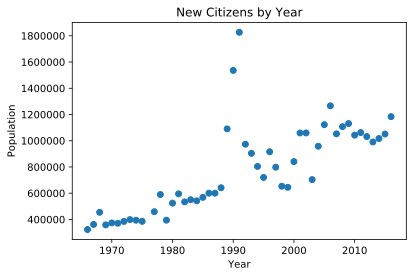

In [6]:
# why they spiked in 1990 - 1993, gulf war

x = df[:50].new_citizens
y = df[:50].year
plt.title('New Citizens by Year')
plt.xlabel("Year")
plt.ylabel("Population")
matplotlib.pyplot.scatter(y,x)
matplotlib.pyplot.show()

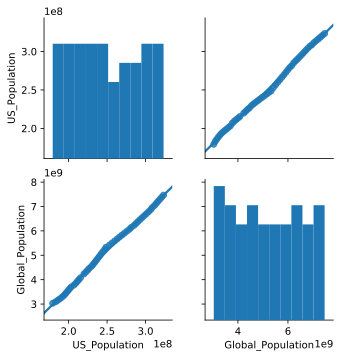

In [7]:
# this shows a linear correlation with the US and Global Populations

sns.pairplot(combine_table, vars=['US_Population', 'Global_Population'], kind='reg');

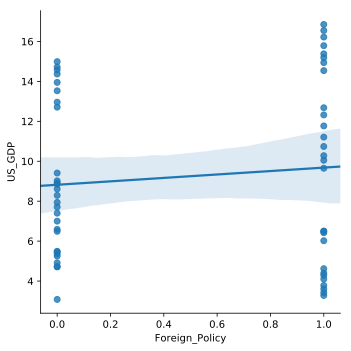

In [8]:
# idk what this shows

sns.lmplot(y='US_GDP', x='Foreign_Policy', data = combine_table);

In [9]:
# preform an ANOVA test on current data

new = ols('new_citizens ~ US_GDP + US_Population + World_GDP + Global_Population + Foreign_Policy', data=combine_table).fit()
table = sm.stats.anova_lm(new, typ=2) # Type 2 ANOVA DataFrame

print(table)

                         sum_sq    df          F    PR(>F)
US_GDP             2.197560e+10   1.0   0.616729  0.435971
US_Population      3.486158e+11   1.0   9.783641  0.002934
World_GDP          1.166201e+10   1.0   0.327286  0.569825
Global_Population  5.743519e+11   1.0  16.118755  0.000200
Foreign_Policy     8.562352e+10   1.0   2.402960  0.127413
Residual           1.781626e+12  50.0        NaN       NaN


In [10]:
combine_table.corr()

,Year,US_GDP,World_GDP,US_Population,Global_Population,Foreign_Policy,new_citizens
Year,1.000000,0.989561,0.986723,0.998110,0.999563,0.069184,0.802592
US_GDP,0.989561,1.000000,0.993845,0.995510,0.991883,0.101631,0.778028
World_GDP,0.986723,0.993845,1.000000,0.992174,0.988796,0.115025,0.776990
US_Population,0.998110,0.995510,0.992174,1.000000,0.998716,0.091342,0.789293
Global_Population,0.999563,0.991883,0.988796,0.998716,1.000000,0.080026,0.804135
Foreign_Policy,0.069184,0.101631,0.115025,0.091342,0.080026,1.000000,-0.100305
new_citizens,0.802592,0.778028,0.776990,0.789293,0.804135,-0.100305,1.000000


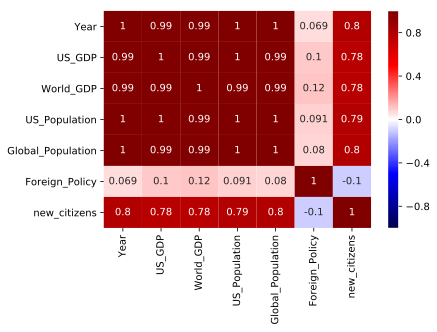

In [11]:
'''all variables are heavily correlated. Foreign Policy is right in the middle because there is an
even 50% split for each as shown in the line below'''

sns.heatmap(combine_table.corr(), cmap='seismic',vmin=-1,vmax=1, annot=True);

In [12]:
# use conditional probability on foreign policy
# currently goes back until 1951
# Based it off of the president because when a president was elected.
# Congress's party fell in line with the party of
# the president except when Nixon, Ford, HW were president.

# Plot all of the variable-to-variable relations as scatterplots
# histograms are within themselves because it is the distribution against itself
# counts the bins the y axis against itself in the x

rating_fp = combine_table.groupby('Foreign_Policy').size().div(len(combine_table))
rating_fp

Foreign_Policy
0    0.5
1    0.5
dtype: float64

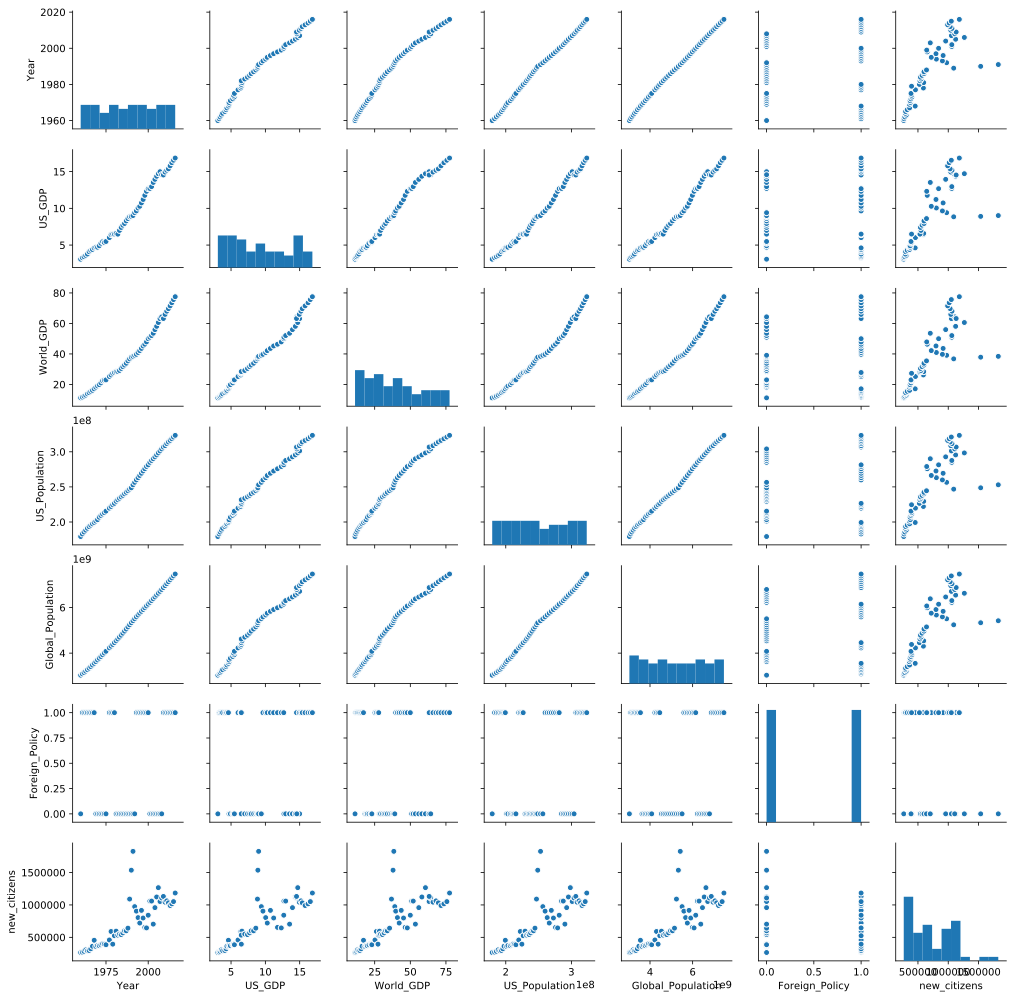

In [13]:
sns.pairplot(combine_table, size = 2, aspect=1);

# Regression

In [14]:
y, X = patsy.dmatrices('new_citizens ~ US_GDP + World_GDP + US_Population + Global_Population + Foreign_Policy', data=combine_table, return_type="dataframe")

# Create model
model1 = sm.OLS(y,X)
# This model fits the whole model to my as my training set
fit1 = model1.fit()
# Print summary statistics of the model's performance
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           new_citizens   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     28.58
Date:                Wed, 25 Apr 2018   Prob (F-statistic):           1.45e-13
Time:                        17:46:19   Log-Likelihood:                -756.59
No. Observations:                  56   AIC:                             1525.
Df Residuals:                      50   BIC:                             1537.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          5.162e+06   1.98e+06      2.606      0.012    1.18e+06    9.14e+06
US_GDP             6.301e+04   8.02e+04      0.785      0.436   -9.82e+04    2.24e+05
World_GDP          7173.2922   1.25e+04      0.572      0.570    -1.8e+04    3.24e+04
US_Population        -0.0574      0.018     -3.128      0.003      -0.094      -0.021
Global_Population     0.0018      0.000      4.015      0.000       0.001       0.003
Foreign_Policy     -8.14e+04   5.25e+04     -1.550      0.127   -1.87e+05    2.41e+04
==============================================================================
Omnibus:                       37.716   Durbin-Watson:                   1.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              136.462
Skew:                           1.790   Prob(JB):                     2.33e-30
Kurtosis:                       9.758   Cond. No.                     4.21e+11
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.21e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

> Since the R^2 dropped and the adjusted R^2 only increased by 0.002, I will include both GDPs even though their p-values are high

In [15]:
# use the first fit because the r^2 dropped by taking out the GDPs, even though their p-values are
# high

fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           new_citizens   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     28.58
Date:                Wed, 25 Apr 2018   Prob (F-statistic):           1.45e-13
Time:                        17:46:19   Log-Likelihood:                -756.59
No. Observations:                  56   AIC:                             1525.
Df Residuals:                      50   BIC:                             1537.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          5.162e+06   1.98e+06      2.606      0.012    1.18e+06    9.14e+06
US_GDP             6.301e+04   8.02e+04      0.785      0.436   -9.82e+04    2.24e+05
World_GDP          7173.2922   1.25e+04      0.572      0.570    -1.8e+04    3.24e+04
US_Population        -0.0574      0.018     -3.128      0.003      -0.094      -0.021
Global_Population     0.0018      0.000      4.015      0.000       0.001       0.003
Foreign_Policy     -8.14e+04   5.25e+04     -1.550      0.127   -1.87e+05    2.41e+04
==============================================================================
Omnibus:                       37.716   Durbin-Watson:                   1.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              136.462
Skew:                           1.790   Prob(JB):                     2.33e-30
Kurtosis:                       9.758   Cond. No.                     4.21e+11
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.21e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Accuracy Score

In [16]:
lr1 = LinearRegression()

X = combine_table.iloc[:,1:6]
# All variables in the data set will be the response variables
y = combine_table.iloc[:,0]
# Fit the model to the full dataset
lr1.fit(X,y)
# Print out the R^2 for the model against the full dataset
lr1.score(X,y)

0.9996054060638632

In [17]:
X.head()

,US_GDP,World_GDP,US_Population,Global_Population,Foreign_Policy
31,3.08,11.20,179322000,3.033213e+09,0
32,3.28,11.68,182976000,3.090305e+09,1
33,3.42,12.33,185739000,3.149244e+09,1
34,3.60,12.97,188434000,3.210271e+09,1
35,3.78,13.84,191085000,3.273671e+09,1


In [18]:
# show the intercept of the linear regression
print(lr1.intercept_)
# show the coefficients of each section in the linear regression
lr1.coef_

1903.815012985497


array([-8.48154578e-01, -1.64615210e-02,  1.65106944e-07,  9.97793380e-09,
       -3.38625873e-01])

# Log New Citizens (y value)

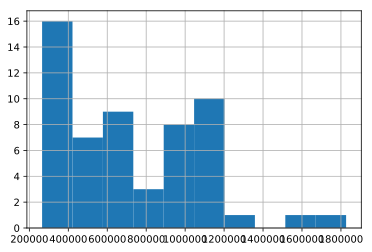

In [19]:
combine_table.new_citizens.hist();

In [20]:
combine_table['new_citizens_log']=np.log(combine_table.new_citizens)

In [21]:
combine_table.head()

,Year,US_GDP,World_GDP,US_Population,Global_Population,Foreign_Policy,new_citizens,new_citizens_log
31,1960,3.08,11.20,179322000,3.033213e+09,0,265398.0,12.488986
32,1961,3.28,11.68,182976000,3.090305e+09,1,271344.0,12.511143
33,1962,3.42,12.33,185739000,3.149244e+09,1,283763.0,12.555895
34,1963,3.60,12.97,188434000,3.210271e+09,1,306260.0,12.632190
35,1964,3.78,13.84,191085000,3.273671e+09,1,292248.0,12.585358


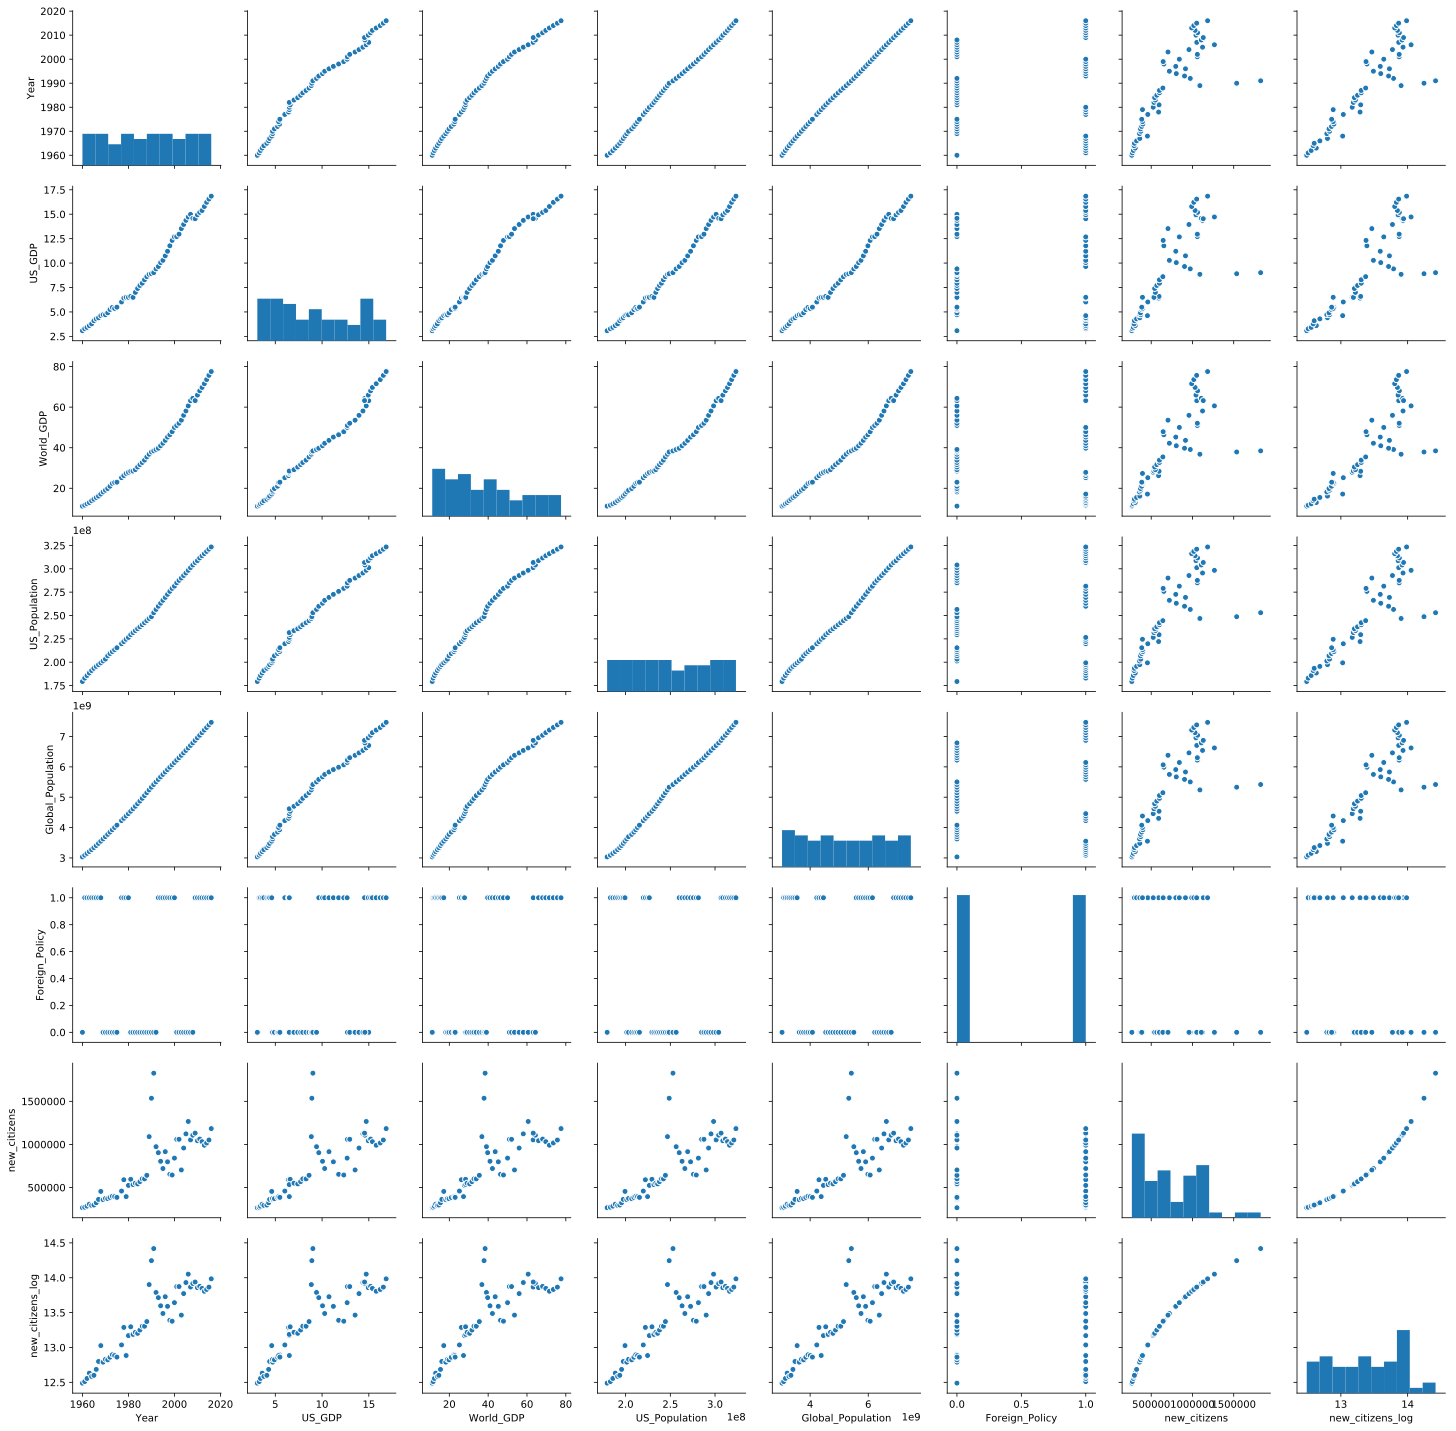

In [22]:
sns.pairplot(combine_table);

In [23]:
y, X = patsy.dmatrices('new_citizens_log ~ US_GDP + World_GDP + US_Population + Global_Population + Foreign_Policy', data=combine_table, return_type="dataframe")

log_model = sm.OLS(y,X)
log_fit = log_model.fit()
log_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       new_citizens_log   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     67.18
Date:                Wed, 25 Apr 2018   Prob (F-statistic):           5.38e-21
Time:                        17:46:24   Log-Likelihood:                 16.416
No. Observations:                  56   AIC:                            -20.83
Df Residuals:                      50   BIC:                            -8.679
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            15.8365      2.004      7.901      0.000      11.811      19.862
US_GDP                0.0084      0.081      0.104      0.918      -0.155       0.172
World_GDP            -0.0075      0.013     -0.589      0.558      -0.033       0.018
US_Population     -5.204e-08   1.86e-08     -2.804      0.007   -8.93e-08   -1.48e-08
Global_Population  2.086e-09   4.42e-10      4.716      0.000     1.2e-09    2.97e-09
Foreign_Policy       -0.0967      0.053     -1.819      0.075      -0.203       0.010
==============================================================================
Omnibus:                       13.311   Durbin-Watson:                   1.064
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               16.229
Skew:                           0.914   Prob(JB):                     0.000299
Kurtosis:                       4.900   Cond. No.                     4.21e+11
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.21e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

> Remove both GDPs b/c high p-values, then possibly foreign policy

> Keep both GDPs b/c R^2 lower by 0.001, adjusted R^2 only went up by 0.003

In [24]:
log_fit.summary() # first log

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       new_citizens_log   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     67.18
Date:                Wed, 25 Apr 2018   Prob (F-statistic):           5.38e-21
Time:                        17:46:24   Log-Likelihood:                 16.416
No. Observations:                  56   AIC:                            -20.83
Df Residuals:                      50   BIC:                            -8.679
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            15.8365      2.004      7.901      0.000      11.811      19.862
US_GDP                0.0084      0.081      0.104      0.918      -0.155       0.172
World_GDP            -0.0075      0.013     -0.589      0.558      -0.033       0.018
US_Population     -5.204e-08   1.86e-08     -2.804      0.007   -8.93e-08   -1.48e-08
Global_Population  2.086e-09   4.42e-10      4.716      0.000     1.2e-09    2.97e-09
Foreign_Policy       -0.0967      0.053     -1.819      0.075      -0.203       0.010
==============================================================================
Omnibus:                       13.311   Durbin-Watson:                   1.064
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               16.229
Skew:                           0.914   Prob(JB):                     0.000299
Kurtosis:                       4.900   Cond. No.                     4.21e+11
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.21e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [25]:
from sklearn.cross_validation import cross_val_score
reg = LinearRegression()
scores = cross_val_score(reg, X, y, cv=10, scoring='mean_squared_error')

# scores output is negative, a sklearn quirk bc mse is used to min. optimization func.
print(-scores)

[0.03746562 0.03865256 0.02010162 0.01834378 0.08250962 0.10489484
 0.05253596 0.04926378 0.02019147 0.15318171]


/Users/cyrusrustomji/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/cyrusrustomji/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/cyrusrustomji/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/cyrusrustomji/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.

In [26]:
np.mean(-scores)

0.05771409684328312

### Accuracy Score of model without logging using train/test split

In [27]:
linear = LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
linear.fit(X_train,y_train)
linear.score(X_test,y_test)

0.8606998659556196

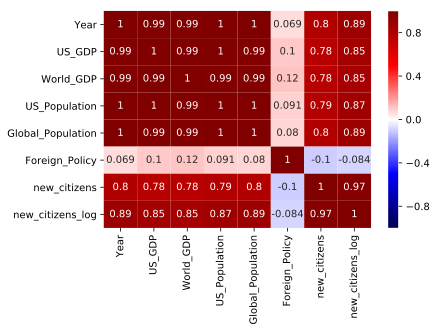

In [28]:
sns.heatmap(combine_table.corr(), cmap='seismic',vmin=-1,vmax=1, annot=True);

In [29]:
combine_table.head()

,Year,US_GDP,World_GDP,US_Population,Global_Population,Foreign_Policy,new_citizens,new_citizens_log
31,1960,3.08,11.20,179322000,3.033213e+09,0,265398.0,12.488986
32,1961,3.28,11.68,182976000,3.090305e+09,1,271344.0,12.511143
33,1962,3.42,12.33,185739000,3.149244e+09,1,283763.0,12.555895
34,1963,3.60,12.97,188434000,3.210271e+09,1,306260.0,12.632190
35,1964,3.78,13.84,191085000,3.273671e+09,1,292248.0,12.585358


In [30]:
lr5 = LinearRegression()

X = combine_table.iloc[:,1:6]
# All variables in the data set will be the response variables
y = combine_table.iloc[:,-1]
# Fit the model to the full dataset
lr1.fit(X,y)
# Print out the R^2 for the model against the full dataset
lr1.score(X,y)

0.8704338821887438

In [31]:
combine_table.head()

,Year,US_GDP,World_GDP,US_Population,Global_Population,Foreign_Policy,new_citizens,new_citizens_log
31,1960,3.08,11.20,179322000,3.033213e+09,0,265398.0,12.488986
32,1961,3.28,11.68,182976000,3.090305e+09,1,271344.0,12.511143
33,1962,3.42,12.33,185739000,3.149244e+09,1,283763.0,12.555895
34,1963,3.60,12.97,188434000,3.210271e+09,1,306260.0,12.632190
35,1964,3.78,13.84,191085000,3.273671e+09,1,292248.0,12.585358


In [32]:
# combine_table_log = combine_table_log.to_pickle('new_citizens_log.pkl')
combine_table_log = pd.read_pickle('new_citizens_log.pkl')

# Regularization

In [33]:
combine_table_log.head()

,Year,US_GDP,World_GDP,US_Population,Global_Population,Foreign_Policy,new_citizens_log
31,1960,3.08,11.20,179322000,3.033213e+09,0,12.488986
32,1961,3.28,11.68,182976000,3.090305e+09,1,12.511143
33,1962,3.42,12.33,185739000,3.149244e+09,1,12.555895
34,1963,3.60,12.97,188434000,3.210271e+09,1,12.632190
35,1964,3.78,13.84,191085000,3.273671e+09,1,12.585358


In [34]:
X = combine_table_log.drop(['new_citizens_log','Year'],axis=1)
y = combine_table_log['new_citizens_log']
X.shape
kf = KFold(n_splits=5,shuffle=True)

In [35]:
X.head()

,US_GDP,World_GDP,US_Population,Global_Population,Foreign_Policy
31,3.08,11.20,179322000,3.033213e+09,0
32,3.28,11.68,182976000,3.090305e+09,1
33,3.42,12.33,185739000,3.149244e+09,1
34,3.60,12.97,188434000,3.210271e+09,1
35,3.78,13.84,191085000,3.273671e+09,1


In [36]:
y.head()

31    12.488986
32    12.511143
33    12.555895
34    12.632190
35    12.585358
Name: new_citizens_log, dtype: float64

In [52]:
# Elastic Net

from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
alpha = 1e-5
enet = ElasticNet(alpha=alpha)
y_pred_enet = enet.fit(X, y)
y_pred_enet.score(X,y)

/Users/cyrusrustomji/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.8667733719436378

> Do a Polynomial Fit

In [38]:
from scipy import stats
from sklearn import preprocessing

In [39]:
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(combine_table)
combine_normalized = pd.DataFrame(np_scaled)
combine_normalized.head()

,0,1,2,3,4,5,6,7
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1,0.017857,0.014524,0.007234,0.025360,0.012877,1.0,0.003809,0.011486
2,0.035714,0.024691,0.017031,0.044537,0.026170,1.0,0.011763,0.034686
3,0.053571,0.037763,0.026677,0.063241,0.039934,1.0,0.026174,0.074238
4,0.071429,0.050835,0.039789,0.081640,0.054234,1.0,0.017198,0.049960


> Do Regularization

In [40]:
# do regularization on all variables (use lasso for GDPs because both coeeffs are high)
    # lasso brings coeffs to 0
# look at how conditional, continuous, and intro to prob could affect the data

In [41]:
# what to do for foreign policy

# have training sets and test sets
# have multiple training and test sets
# we want cross validation (test error) is the lowest